In [5]:
from IPython.display import Image
from IPython.core.display import HTML 
HTML('''<script> $('div .input').hide()''')
Image(url= "https://i0.wp.com/kpmgeestiblog.ee/wp-content/uploads/2018/12/cropped-LOGIO_KPMG_NoCP_RGB_280-2.png?resize=110%2C51&ssl=1")

## Visualizing Document Turnover

After going through 30K potential link candidates, a number of MS Excel files were downloaded

660 of the entries in those files have field "Dokumendi kuupäev" (just "Kuupäev" in the table) set to May. These entries will now serve as input data enabling to undertand these research questions:

1. What is the source (sources) of document turnover
2. What is the destination (destinations) of document turnover
3. What types of documents there are, which are created

I consolidated results in single MS Excel file 'FINAL_MAY_2021.xlsx'
and review its contents

In [2]:
import pandas as pd

may2021 = pd.read_excel('FINAL_MAY_2021.xlsx') 

may2021.head(2)

,URL,Kellelt,Kellele,Väljaandja,Dok No,Kuupäev,Dok Tüüp,Dok Klass,AK
0,https://dhs.riigikantselei.ee/avalikteave.nsf/...,NaN,Riigikogu juhatus,NaN,21-00034-18,03.05.2021,Kiri,07 Vabariigi Valitsuse ja peaministri muu asja...,NaN
1,https://dhs.riigikantselei.ee/avalikteave.nsf/...,Põlvamaa Omavalitsuste Liit,NaN,NaN,21-01048-3,03.05.2021,Kiri,07 Vabariigi Valitsuse ja peaministri muu asja...,NaN


Next, I make some ETL to the file, preparing it for analysis

1. Making Date ensitive ("Kuupäev" is data type "datetime")
2. Combining all ministries together into aggregatory "Ministeeriumid"

In [4]:
may2021.index = pd.to_datetime(may2021['Kuupäev'])
# Change Kellelt to summarize all ministeeriumid
import numpy as np
may2021['From'] = np.where(may2021['Kellelt'].str.find('ministeerium') > -1, 'Ministeerium', may2021['Kellelt'])
may2021['To'] = np.where(may2021['Kellele'].str.find('ministeerium') > -1, 'Ministeerium', may2021['Kellele'])

Next, I visualize the following fields:
    
    ['Kellelt', 'Kellele', 'Väljaandja', 'Dok No', 'Kuupäev', 'Dok Tüüp']

In English would be:
    
    ['From', 'To', 'Issuer', 'No of Doc', 'Date', 'Type of Doc']
    
As bar-charts, to see distributions.
I only take<b> 5 most active values </b>from each data category

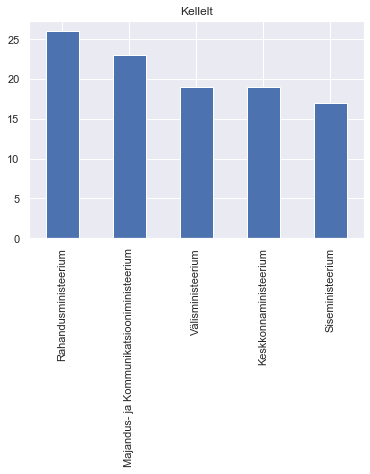

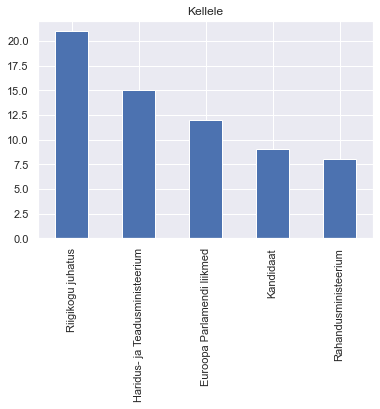

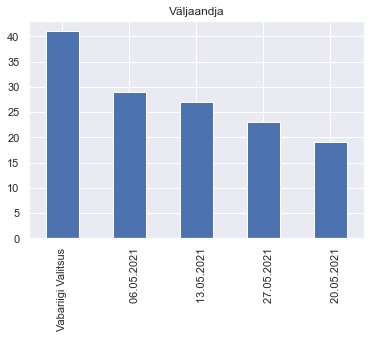

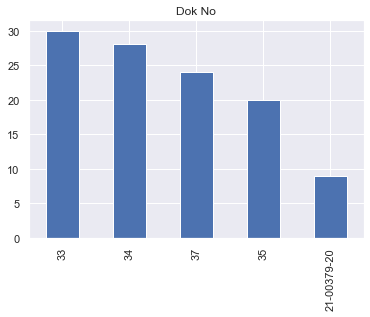

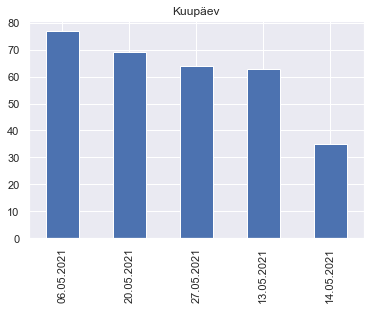

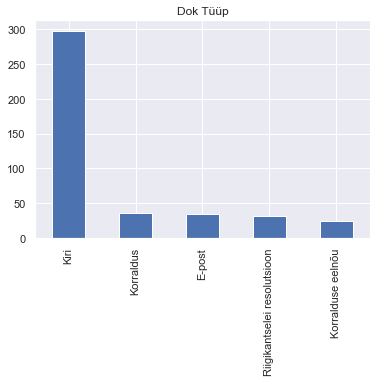

In [5]:
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
sns.set()

for attribute in ['Kellelt', 'Kellele', 'Väljaandja', 'Dok No', 'Kuupäev', 'Dok Tüüp']:
    may2021[attribute].value_counts()[0:5].plot(kind='bar', title = attribute)
    plt.show()

Below, I use analytical, aggreggated distribution of "Ministeeriumid", which is all ministries together. This changes the picture: "From" now is very actively the ministries

<AxesSubplot:title={'center':'Received From'}>

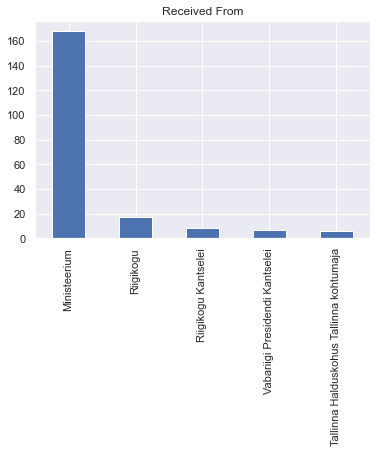

In [6]:
may2021['From'].value_counts()[0:5].plot(kind='bar', title = "Received From")

Below, I use analytical, aggreggated distribution of "Ministeeriumid", which is all ministries together. This changes the picture: "To" now is very actively the ministries

<AxesSubplot:title={'center':'Sent To'}>

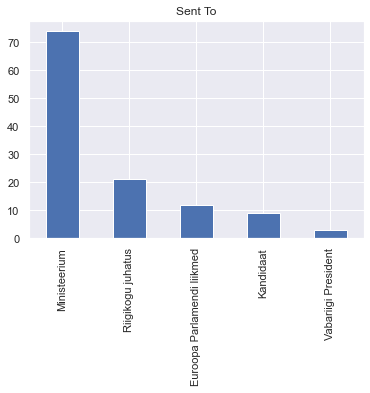

In [7]:
may2021['To'].value_counts()[0:5].plot(kind='bar', title = "Sent To")

Here I create another agreggation. All document types, which have, at the same type, no source ("From") and no destination ("To"), or the list of their destinations, or sources, is too long (for example all ministries, or many foreign countries, are listed, as destination of a single document, in the field "To"), these document types are now designated "Kogu üldsusele" ("To all public")

In [8]:
may2021['To'] = np.where(may2021['Kellele'].isnull() & may2021['Kellelt'].isnull(), 'Kogu üldsusele', may2021['To'])

<AxesSubplot:title={'center':'Sent To'}>

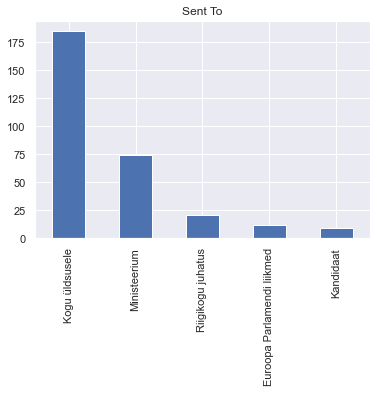

In [9]:
may2021['To'].value_counts()[0:5].plot(kind='bar', title = "Sent To")

<AxesSubplot:>

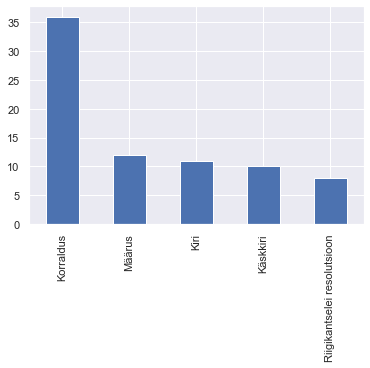

In [10]:
may2021[may2021['Kellele'].isnull() & may2021['Kellelt'].isnull()]['Dok Tüüp'].value_counts()[0:5].plot(kind = 'bar')

Here I also list some statistics by doc type: many documents are letters, but some are government orders ("korraldus")

In [11]:
may2021['Dok Tüüp'].value_counts()

Kiri                                  298
Korraldus                              36
E-post                                 34
Riigikantselei resolutsioon            31
Korralduse eelnõu                      24
Kabinetinõupidamise materjalid         23
Seaduse eelnõu                         18
Protokolli märgitava otsuse eelnõu     14
Määruse eelnõu                         13
Määrus                                 12
Käskkiri                               10
Riigisekretäri resolutsioon             9
Peaministri resolutsioon                5
Töövõtuleping                           2
Veateade                                2
Tööleping                               2
kiri                                    1
Teenuse osutamise leping                1
Eelnõu kooskõlastamiseks                1
Riigikogu otsuse eelnõu                 1
Name: Dok Tüüp, dtype: int64

Finally, I visualize 5 most active sources and 5 most prevailing destinations of document turnover, using NetworkX and Matplotlib

The first picture (below) are the sources with ministries the strongst source with all others - like the parliament - far behind

<Figure size 936x1296 with 0 Axes>

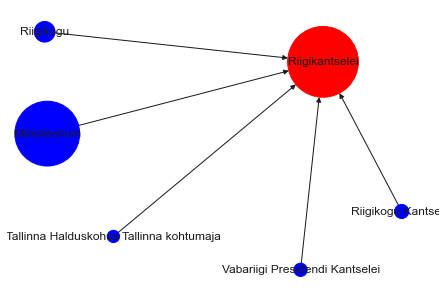

<Figure size 936x1296 with 0 Axes>

In [115]:
import matplotlib.pyplot as plt
import networkx as nx
G = nx.DiGraph()

G.add_node('Riigikantselei', color = 'red', node_shape = 's')
node_sizes =[5000]
node_shapes = ['o']
node_colors = ['red']

for body, size_ in zip(may2021['From'].value_counts()[0:5].index, may2021['From'].value_counts()[0:5].values):
    node_sizes.append(int(size_ * 25))
    node_shapes.append('o')
    node_colors.append('blue')
    G.add_node(body, node_size = size_)
    
    G.add_edge(body, 'Riigikantselei')

nx.draw_spring(G, with_labels=True, node_size = node_sizes, node_color = node_colors)
plt.figure(figsize=(13,18))

Below, I similarly list destinations of information

Most output correspondences are general orders directed to everyone. But some go to the ministires

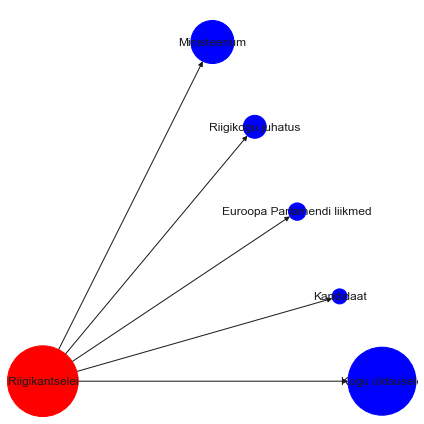

In [153]:
import networkx as nx
G_out = nx.DiGraph()

G_out.add_node('Riigikantselei', color = 'red', node_shape = 's')
node_sizes =[5000]
node_shapes = ['o']
node_colors = ['red']

for body, size_ in zip(may2021['To'].value_counts()[0:5].index, may2021['To'].value_counts()[0:5].values):
    node_sizes.append(int(size_ * 25))
    node_shapes.append('o')
    node_colors.append('blue')
    G_out.add_node(body, node_size = size_)
    
    G_out.add_edge('Riigikantselei', body)
plt.figure(figsize=(5.7,5.7))
nx.draw_planar(G_out, with_labels=True, node_size = node_sizes, node_color = node_colors)


Finally, what types of documents, if only those, who do not have easily defined sender or receiver, there are?

In the picture below it seems that those are resolutions, orders, prescriptions with also some letters.

<AxesSubplot:>

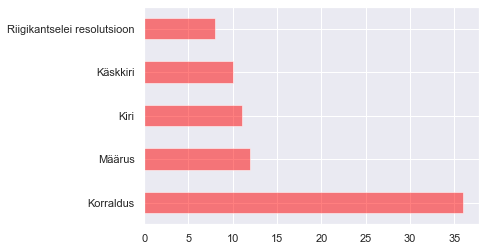

In [161]:
may2021[may2021['Kellele'].isnull() & may2021['Kellelt'].isnull()]['Dok Tüüp'].value_counts()[0:5].plot(kind = 'barh', 
                                                                                                        color = 'red',
                                                                                                       alpha = 0.5)